In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report

In [2]:
path = 'ex3data1.mat'
data = loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape


((5000, 400), (5000, 1))

### data-visualization


In [4]:
# random show 100 datas
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx,:]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

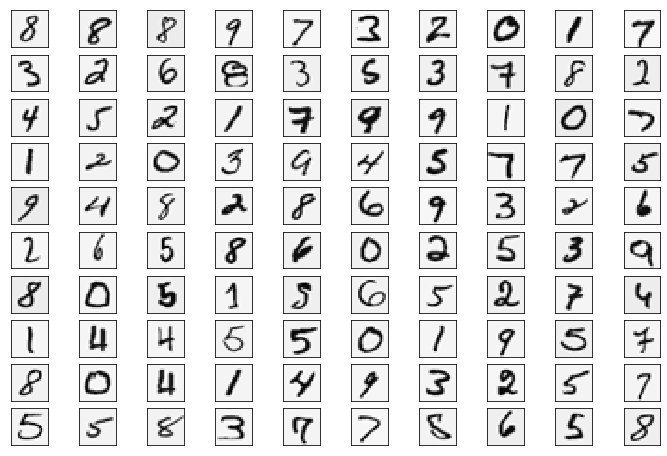

In [5]:
# visualization
fig,ax_array = plt.subplots(nrows=10,ncols=10,
                        sharex=True,sharey=True,
                        figsize=(12,8))
for r in range(10):
    for c in range(10):
        ax_array[r,c].matshow(
        np.array(sample_images[10*r+c].reshape((20,20))).T,
        cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

#### Logistic Regression --vectorization

##### sigmoid function

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


##### cost function`

In [7]:
def costf(theta,X,y,learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y,np.log(sigmoid(X*theta.T)))
    second = np.multiply(1-y,np.log(1-sigmoid(X*theta.T)))
    regularization = (learningRate/(2*len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]],2))
    return np.sum(first-second) / len(X) +regularization


##### gradient--vectorization

In [8]:
def gradient(theta,X,y,learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X*theta.T) - y
    
    grad = ((X.T*error) / len(X)).T + (theta*(learningRate/len(X)))
    
    # intetcept gradient is not regularized
    # because when j=0，don't regularization ,so need to reset
    grad[0,0] = np.sum(np.multiply(error,X[:,0])) / len(X)
    return np.array(grad).ravel()


### one to many  classification

In [9]:
from scipy.optimize import minimize

def one_vs_all(X,y,num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    all_theta = np.zeros((num_labels,params+1))
    X = np.insert(X,0,values = np.ones(rows),axis = 1)
    
    for i in range(1,num_labels+1):
        theta = np.zeros(params+1)
        y_i = np.array([1 if label == i else 0 for label in y])  # 从后向前看这条语句
        y_i = np.reshape(y_i, (rows, 1))
        
        fmin = minimize(fun=costf, x0=theta, args=(X,y_i,learning_rate),
                       method="TNC", jac=gradient)
        all_theta[i-1,:] = fmin.x
        
    return all_theta


In [10]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params+1))

X = np.insert(data['X'],0,values=np.ones(rows),axis=1)

theta = np.zeros(params+1)
y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0,(rows, 1))
X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [11]:
np.unique(data['y'])


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [12]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-2.38306727e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30413814e-03, -6.87770764e-10,  0.00000000e+00],
       [-3.18164801e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45683531e-03, -5.08130080e-04,  0.00000000e+00],
       [-4.79603331e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86997121e-05, -2.47471427e-07,  0.00000000e+00],
       ...,
       [-7.98571054e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95941134e-05,  7.23456794e-06,  0.00000000e+00],
       [-4.57066215e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33906537e-03,  1.00042428e-04,  0.00000000e+00],
       [-5.40305845e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16547324e-04,  7.87683857e-06,  0.00000000e+00]])

In [13]:
def predict_all(X,all_theta):
    row = X.shape[0]   # 5000
    params = X.shape[1]  # 400
    num_labels = all_theta.shape[0]  # 10
    
    X = np.insert(X,0,values = np.ones(rows),axis=1)  # axis=1 行方向 
    # convert to matrices
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)
    
    # compute the class probability for each class on each training instance
    h = sigmoid(X * all_theta.T)
    
    # create array of the index with the maximum probability
    h_argmax = np.argmax(h, axis=1)
    
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

In [37]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a==b else 0 for (a,b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int,correct))/float(len(correct)))
print("accuracy = {0}%".format(accuracy*100))
print("-------------------------------------")
print(classification_report(data['y'], y_pred))


accuracy = 94.46%
-------------------------------------
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 2. Netural Network

## forward network and predict

In [16]:
weight = loadmat('ex3weights.mat')
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape
# (25,401), (10,25)


((25, 401), (10, 26))

In [18]:
# insert constant

X2 = np.matrix(np.insert(data['X'],0,values=np.ones(X.shape[0]),axis=1))
y2 = np.matrix(data['y'])

X2.shape,y2.shape


((5000, 401), (5000, 1))

In [21]:
a1 = X2
z2 = a1*theta1.T
z2.shape

(5000, 25)

In [47]:
a2 = sigmoid(z2)
a2.shape

(5000, 25)

In [48]:
a2 = np.insert(a2,0,values=np.ones(a2.shape[0]),axis=1) 
# 5000 ， 26
z3 = a2 * theta2.T
z3.shape

(5000, 10)

In [40]:
a3 = sigmoid(z3)
# 5000 ，10
a3

matrix([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

In [30]:
y_pred2 = np.argmax(a3, axis=1)+ 1
y_pred2.shape

(5000, 1)

In [33]:
print(classification_report(y2,y_pred2))


              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

